## Creating Adversarial Examples Using FGSM
This notebook is part of Module 1 of the [ODSC Europe 2021](https://odsc.com/europe/) workshop [Adversarial Attacks and Defence in Computer Vision 101](https://odsc.com/speakers/adversarial-attacks-and-defence-in-computer-vision-101/).  
![ODSC Logo](https://opendatascience.com/wp-content/uploads/2021/01/odsceutop.png)  
The method used is FGSM (Fast Gradient Sign Method). The attack is performed to a [Inception V3](https://paperswithcode.com/method/inception-v3) model trained on [ImageNet](https://www.image-net.org/).  
This notebook can be executed in a CPU runtime with good performance. No need to connect it to a GPU or TPU runtime.

### Preparation
Import all the necessary Python dependencies first. The [Keras](https://keras.io/) API in [TensorFlow](https://www.tensorflow.org/) 2 will be used. [Matplotlib](https://matplotlib.org/) is used for images display. [Plotly](https://plotly.com/python/getting-started/#overview) is used for charts.

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import save_img
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Download the Keras pretrained on ImageNet Inception V3 model.

In [25]:
pretrained_model = InceptionV3(weights='imagenet')
pretrained_model.trainable = False

### Classification  
Define a function to preprocess the input images for the Inception V3 neural network.

In [26]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (299, 299))
  image = preprocess_input(image)
  image = image[None, ...]
  return image

Define a function to decode the predictions.

In [27]:
def get_imagenet_label(probs, top=1):
  return decode_predictions(probs, top)[0][0]

Upload an image.

In [28]:
from google.colab import files

uploaded = files.upload()

Saving action-asphalt-auto-210019.jpg to action-asphalt-auto-210019 (1).jpg


Decode the uploaded image.

In [29]:
for key in uploaded.keys():
  img_path = './' + key
  image_raw = tf.io.read_file(img_path)
  image = tf.image.decode_image(image_raw)

In [30]:
image.shape

TensorShape([853, 1280, 3])

Proeprocess the image to make it ready to be passed as input to the Inception V3 model. 

In [31]:
image = preprocess(image)

Classify the uploaded image.

In [32]:
image_probs = pretrained_model.predict(image)

Display the uploaded image and the top classification result.

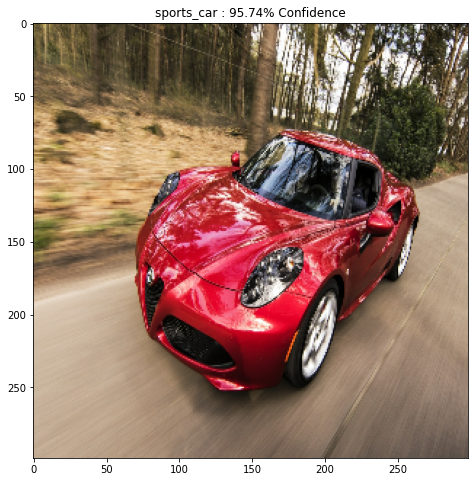

In [33]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

Display the top 5 predictions from the model for the uploaded image.

In [34]:
top5_probs = np.flip(np.sort(image_probs)[0][-5:])
top_prob_id = np.argmax(image_probs)
top5_decoded_probs = tf.keras.applications.imagenet_utils.decode_predictions(
    image_probs, top=5
)
x_labels=[top5_decoded_probs[0][idx][1] for idx in range(0, 5)]

In [35]:
fig = go.Figure(data=[go.Bar(x=x_labels, y=top5_probs,
               hovertext=top5_probs)])
fig.update_traces(marker_color='rgb(158,202,225)', 
                  marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Top 5 Predictions')
fig.show()

### Adversarial Attack
We are going to create adversarial samples using the FGSM technique. It has been introduced in [this paper](https://arxiv.org/abs/1412.6572):    
$adv_x = x + \epsilon * sign(\nabla{x}J(\theta,x,y))$  
This method computes the gradients of a loss function with respect to the input image and then uses the sign of the gradients to create the adversarial image that maximizes the loss. $\epsilon$ is the multiplier to ensure that the perturbations are small.

Choose a loss function.

In [36]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

Implement a function to create the adversarial patterns through the FGSM method.

In [37]:
def create_adversarial_pattern(input_image, pretrained_model, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  
  signed_grad = tf.sign(gradient)
  return signed_grad

Get the input label for the chosen image.

In [38]:
label = tf.one_hot(top_prob_id, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

Create the perturbations.

In [39]:
perturbations = create_adversarial_pattern(image, pretrained_model, label)

And display them.

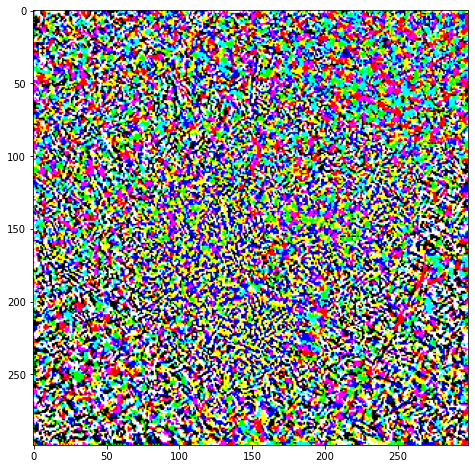

In [40]:
plt.imshow(perturbations[0] * 0.5 + 0.5)

Define a function to display the perturbed images.

In [41]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

Generate adversarial samples using differnt values of epsilon and display them along with the confidence from the model for each.

In [43]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])
  save_img('FGSM_' + str(i) + '_' + str(eps) + '.jpg', adv_x[0])

Output hidden; open in https://colab.research.google.com to view.